# Desafio Universidade dos Dados – Auxiliando os Times de Marketing e Pricing da Empresa de Delivery

Trabalhamos em uma empresa de delivery, em um time de dados centralizado que atende a diversas áreas e recebemos algumas demandas:

- Numa ação de marketing, para atrair mais entregadores, vamos dar uma bonificação para os 20 entregadores que possuem maior distância percorrida ao todo. A bonificação vai variar de acordo com o tipo de profissional que ele é e o modelo que ele usa para se locomover (moto, bike, etc). Levante essas informações.
- Além disso, o time de Pricing precisa ajustar os valores pagos aos entregadores. Para isso, eles precisam da distribuição da distância média percorrida pelos motoqueiros separada por estado, já que cada região terá seu preço.
- Por fim, o CFO precisa de alguns indicadores de receita para apresentar para a diretoria executiva. Dentre esses indicadores, vocês precisarão levantar (1) a receita média e total separada por tipo (Food x Good), (2) A receita média e total por estado. Ou seja, são 4 tabelas ao todo.
- Se a empresa tem um gasto fixo de 5 reais por entrega, recebe 15% do valor de cada entrega como receita e, do total do lucro, distribui 20% em forma de bônus para os 2 mil funcionários, quanto cada um irá receber no período contido no dataset?

![deli](https://api-club-file.cb.hotmart.com/public/v5/files/9711f751-25cd-468f-869a-e92a9eca2362)

# 1. Preparação do ambiente

## 1.1. Importação das bibliotecas e carregamento dos dados

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np
import sqlalchemy

# Análise Exploratória de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações do notebook
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
my_palette = sns.color_palette(["#651A19", "#6F1D1B", "#BB9457", "#7F5E38", "#432818", "#99582A", "#CC9F69", "#FFE6A7"])
sns.set_palette(my_palette)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 40)

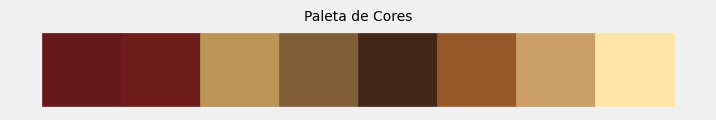

In [2]:
plt.figure(figsize=(8, 1))

for i, cor in enumerate(my_palette):
    plt.fill_between([i, i + 1], 0, 1, color=cor)

plt.axis('off')
plt.title('Paleta de Cores', fontsize = 10)
plt.show()

In [3]:
db_path = '../data/processed/database.db'
engine = sqlalchemy.create_engine(f"sqlite:///{db_path}")

with open ('query.sql', 'r') as open_file:
    query = open_file.read()

df = pd.read_sql(query, engine)

## 1.2. Check-up dos dados

O dataset utilizado foi gerado a partir de uma séries de consultas SQL a partir dos dados originais, agora é o momento de observar sua estrutura.

In [4]:
print(f"O dataset tem {df.shape[0]} linhas e {df.shape[1]} colunas.")
print(f"Possui {len(df.select_dtypes(include = 'number').columns.to_list())} colunas numéricas.")
print(f"Possui {len(df.select_dtypes(include = 'object').columns.to_list())} colunas categóricas.")

O dataset tem 418855 linhas e 11 colunas.
Possui 7 colunas numéricas.
Possui 4 colunas categóricas.


In [5]:
df.head()

,dt_ref,order_id,store_id,payment_amount,payment_fee,order_revenue,driver_id,delivery_distance_meters,driver_modal,store_segment,hub_state
0,2024-07-08,68410055,2181,118.44,0.00,12.7660,10239.0,1035.0,BIKER,GOOD,RJ
1,2024-07-08,68410055,2181,394.81,7.90,53.0365,10239.0,1035.0,BIKER,GOOD,RJ
2,2024-07-08,68412721,631,206.95,5.59,25.2040,8378.0,5714.0,MOTOBOY,FOOD,SP
3,2024-07-08,68413340,631,58.80,1.59,3.5815,8378.0,5199.0,MOTOBOY,FOOD,SP
4,2024-07-08,68414018,3265,45.80,0.92,1.7320,10463.0,3746.0,MOTOBOY,FOOD,SP


In [6]:
df.tail()

,dt_ref,order_id,store_id,payment_amount,payment_fee,order_revenue,driver_id,delivery_distance_meters,driver_modal,store_segment,hub_state
418850,2024-07-08,93139806,2074,28.0,0.42,-0.8630,NaN,1967.0,None,FOOD,PR
418851,2024-07-08,93139809,707,60.9,1.64,3.8890,61781.0,3735.0,MOTOBOY,FOOD,SP
418852,2024-07-08,93139813,631,140.6,3.80,15.5200,6657.0,3931.0,MOTOBOY,FOOD,SP
418853,2024-07-08,93139814,631,139.3,3.76,15.3310,15528.0,978.0,BIKER,FOOD,SP
418854,2024-07-08,93139817,236,116.6,3.15,12.0175,6646.0,4092.0,MOTOBOY,FOOD,RJ


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418855 entries, 0 to 418854
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   dt_ref                    418855 non-null  object 
 1   order_id                  418855 non-null  int64  
 2   store_id                  418855 non-null  int64  
 3   payment_amount            418855 non-null  float64
 4   payment_fee               418855 non-null  float64
 5   order_revenue             418855 non-null  float64
 6   driver_id                 410228 non-null  float64
 7   delivery_distance_meters  418800 non-null  float64
 8   driver_modal              410228 non-null  object 
 9   store_segment             418855 non-null  object 
 10  hub_state                 418855 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 35.2+ MB


Existem várias entregas com dados nulos em relação aos motoristas e seu meio de transporte. 

In [8]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
order_id,418855.0,82347830.26,6973749.16,68410055.0,76587293.50,83235930.00,87939029.50,93139817.00
store_id,418855.0,1260.66,1181.21,6.0,415.00,780.00,1930.00,4679.00
payment_amount,418855.0,94.12,219.82,0.0,32.90,66.70,121.80,100000.11
payment_fee,418855.0,1.90,4.50,0.0,0.45,1.05,2.73,2000.00
order_revenue,418855.0,8.83,32.31,-5.0,-0.14,4.84,12.78,14695.02
driver_id,410228.0,21012.77,15468.28,133.0,7638.00,18791.00,31048.00,66459.00
delivery_distance_meters,418800.0,7236.69,174960.71,0.0,1162.00,2037.00,3418.00,7251291.00


Existem outliers alarmantes em 'delivery_distance_meters' com uma entrega de absurdos 7251291.00 metros! 

# 2. Processamento dos dados

## 2.1. Nulos e duplicados

In [9]:
df.isnull().sum()

dt_ref                         0
order_id                       0
store_id                       0
payment_amount                 0
payment_fee                    0
order_revenue                  0
driver_id                   8627
delivery_distance_meters      55
driver_modal                8627
store_segment                  0
hub_state                      0
dtype: int64

As entregas com dados nulos dos entregadores devem ser excluídas para atender os propósitos da análise, para os nulos em 'delivery_distance_meters' acredito que a abordagem de preencher com a mediana devido à assimetria nessa variável seja o ideal.

In [10]:
for col in df.columns:
    print(df[col].name)
    print(df[col].duplicated().sum())
    print('=' * 15)


dt_ref
418854
order_id
71726
store_id
417975
payment_amount
398712
payment_fee
416586
order_revenue
390093
driver_id
414287
delivery_distance_meters
403094
driver_modal
418852
store_segment
418853
hub_state
418851


Entre os dados duplicados os únicos que vejo necessidade de deleção são os de 'order_id'.

In [11]:
# Remoção dos nulos

df.dropna(subset=['driver_id', 'driver_modal'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 410228 entries, 0 to 418854
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   dt_ref                    410228 non-null  object 
 1   order_id                  410228 non-null  int64  
 2   store_id                  410228 non-null  int64  
 3   payment_amount            410228 non-null  float64
 4   payment_fee               410228 non-null  float64
 5   order_revenue             410228 non-null  float64
 6   driver_id                 410228 non-null  float64
 7   delivery_distance_meters  410199 non-null  float64
 8   driver_modal              410228 non-null  object 
 9   store_segment             410228 non-null  object 
 10  hub_state                 410228 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 37.6+ MB


In [12]:
# Preenchendo os nulos de 'delivery_distance_meters' com a mediana

dist_median = df['delivery_distance_meters'].median()
df.fillna({'delivery_distance_meters': dist_median}, inplace = True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 410228 entries, 0 to 418854
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   dt_ref                    410228 non-null  object 
 1   order_id                  410228 non-null  int64  
 2   store_id                  410228 non-null  int64  
 3   payment_amount            410228 non-null  float64
 4   payment_fee               410228 non-null  float64
 5   order_revenue             410228 non-null  float64
 6   driver_id                 410228 non-null  float64
 7   delivery_distance_meters  410228 non-null  float64
 8   driver_modal              410228 non-null  object 
 9   store_segment             410228 non-null  object 
 10  hub_state                 410228 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 37.6+ MB


In [13]:
# Remoção dos duplicados

df.drop_duplicates(subset=['order_id'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 340410 entries, 0 to 418854
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   dt_ref                    340410 non-null  object 
 1   order_id                  340410 non-null  int64  
 2   store_id                  340410 non-null  int64  
 3   payment_amount            340410 non-null  float64
 4   payment_fee               340410 non-null  float64
 5   order_revenue             340410 non-null  float64
 6   driver_id                 340410 non-null  float64
 7   delivery_distance_meters  340410 non-null  float64
 8   driver_modal              340410 non-null  object 
 9   store_segment             340410 non-null  object 
 10  hub_state                 340410 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 31.2+ MB


## 2.2. Conversão de dtype

Para prosseguir na análise o dtype melhor indicado para driver_id é INT então será realizada a conversão. 

In [14]:
df['driver_id'] = df.driver_id.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 340410 entries, 0 to 418854
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   dt_ref                    340410 non-null  object 
 1   order_id                  340410 non-null  int64  
 2   store_id                  340410 non-null  int64  
 3   payment_amount            340410 non-null  float64
 4   payment_fee               340410 non-null  float64
 5   order_revenue             340410 non-null  float64
 6   driver_id                 340410 non-null  int32  
 7   delivery_distance_meters  340410 non-null  float64
 8   driver_modal              340410 non-null  object 
 9   store_segment             340410 non-null  object 
 10  hub_state                 340410 non-null  object 
dtypes: float64(4), int32(1), int64(2), object(4)
memory usage: 29.9+ MB


## 2.3. Tratamento de outliers

#### payment_amount

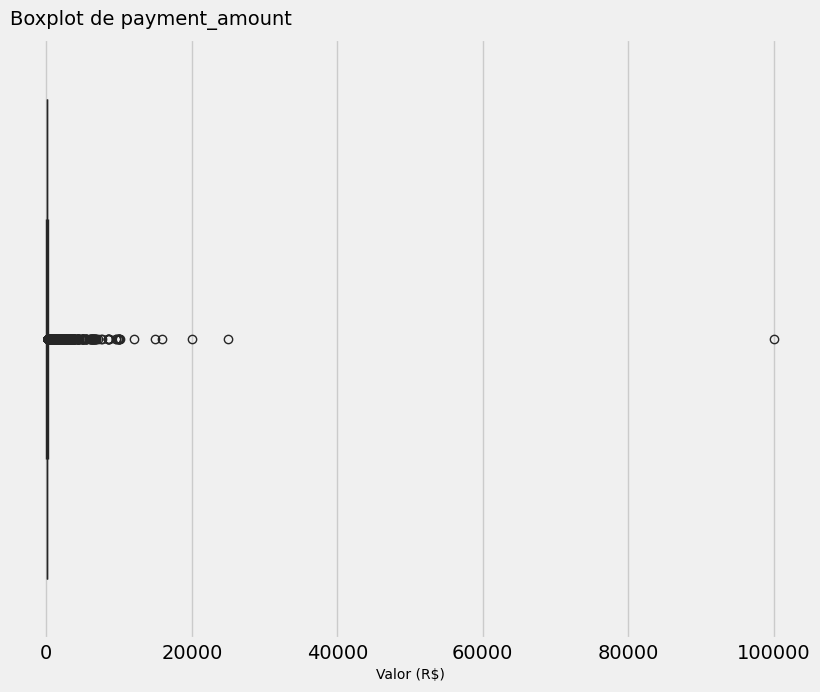

In [15]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0, 0, 1, 1])

sns.boxplot(df, x = 'payment_amount')
ax.set_title('Boxplot de payment_amount', loc = 'left', fontsize = 14, pad = 10)
ax.set_xlabel('Valor (R$)', fontsize = 10)
plt.show()

In [16]:
# Calculando os quartis, e o intervalo interquartil
Q1 = df['payment_amount'].quantile(0.25)
Q3 = df['payment_amount'].quantile(0.75)
IQR = Q3 - Q1

# Calculando os limites inferior e superior
limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

# Outliers
df = df[(df['payment_amount'] >= limite_inf) & (df['payment_amount'] <= limite_sup)]
df.reset_index(inplace = True, drop = True)

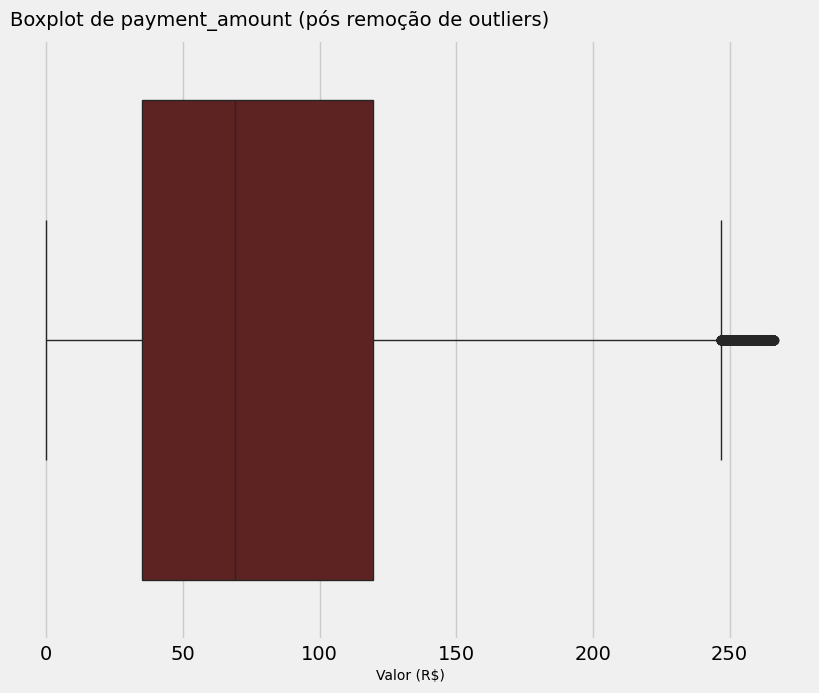

In [17]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0, 0, 1, 1])

sns.boxplot(df, x = 'payment_amount')
ax.set_title('Boxplot de payment_amount (pós remoção de outliers)', loc = 'left', fontsize = 14, pad = 10)
ax.set_xlabel('Valor (R$)', fontsize = 10)
plt.show()

#### payment_fee

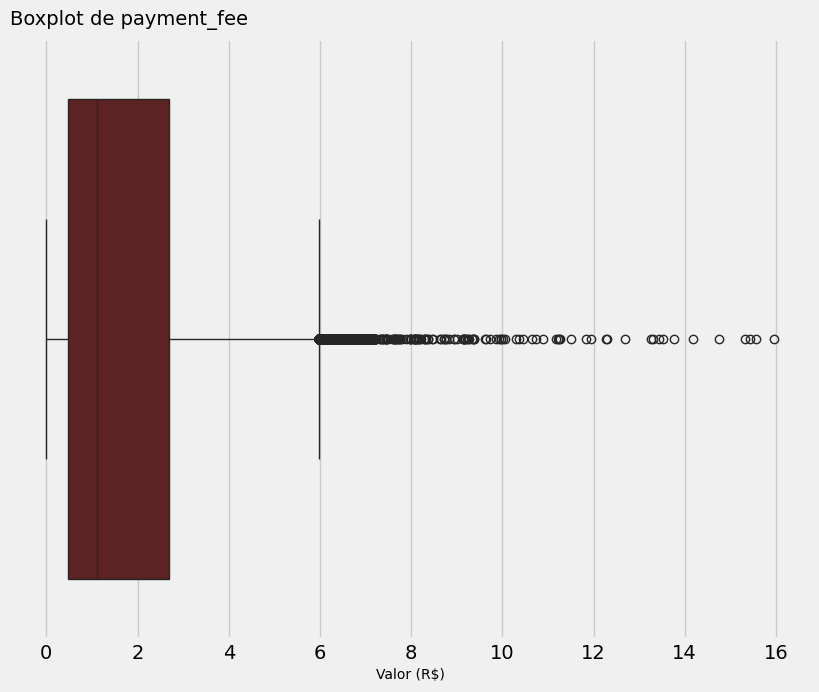

In [18]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0, 0, 1, 1])

sns.boxplot(df, x = 'payment_fee')
ax.set_title('Boxplot de payment_fee', loc = 'left', fontsize = 14, pad = 10)
ax.set_xlabel('Valor (R$)', fontsize = 10)
plt.show()

In [19]:
# Calculando os quartis, e o intervalo interquartil
Q1 = df['payment_fee'].quantile(0.25)
Q3 = df['payment_fee'].quantile(0.75)
IQR = Q3 - Q1

# Calculando os limites inferior e superior
limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

# Outliers
df = df[(df['payment_fee'] >= limite_inf) & (df['payment_fee'] <= limite_sup)]
df.reset_index(inplace = True, drop = True)

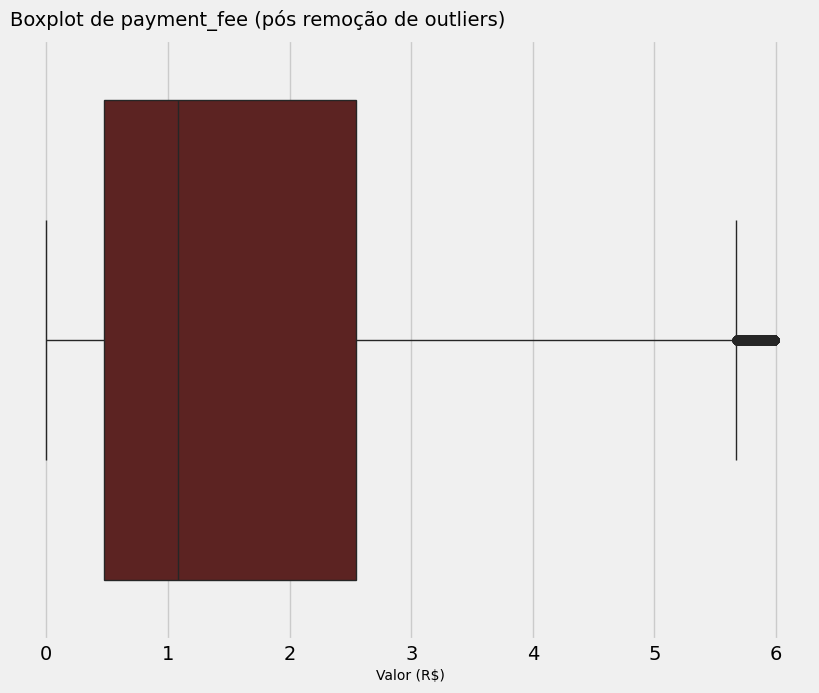

In [20]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0, 0, 1, 1])

sns.boxplot(df, x = 'payment_fee')
ax.set_title('Boxplot de payment_fee (pós remoção de outliers)', loc = 'left', fontsize = 14, pad = 10)
ax.set_xlabel('Valor (R$)', fontsize = 10)
plt.show()

#### delivery_distance_meters

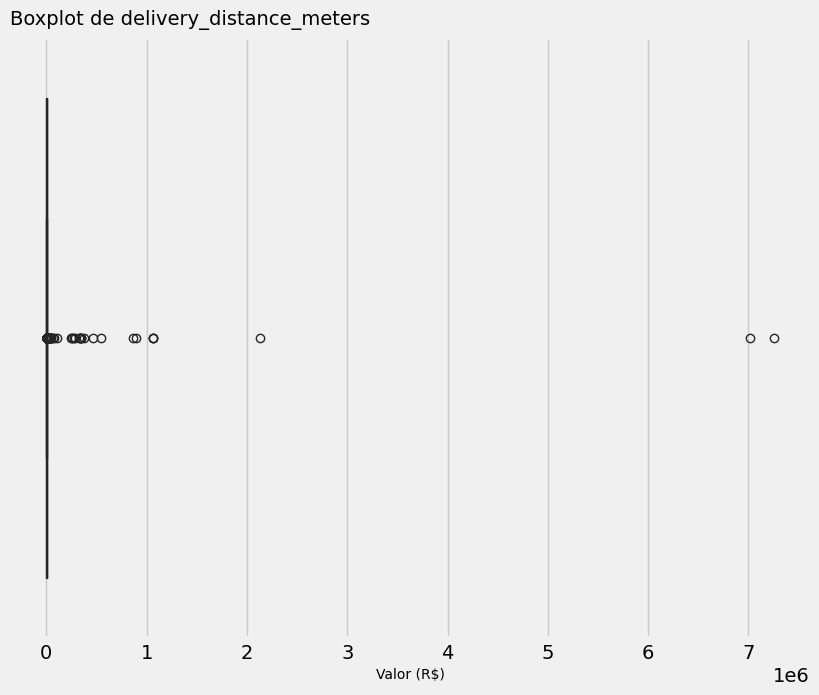

In [21]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0, 0, 1, 1])

sns.boxplot(df, x = 'delivery_distance_meters')
ax.set_title('Boxplot de delivery_distance_meters', loc = 'left', fontsize = 14, pad = 10)
ax.set_xlabel('Valor (R$)', fontsize = 10)
plt.show()

Antes de prosseguir para remoção dos outliers, é preciso ter em mente um fato importante: temos entregadores que usam moto e outros que usam bicicletas. Então é necessário remover os valores extremos dos dois de forma separada. 

In [22]:
# Filtro para os entregadores de bike
filtro = df[df['driver_modal'] == 'BIKER'].index

Q1 = df.loc[filtro, 'delivery_distance_meters'].quantile(0.25)
Q3 = df.loc[filtro, 'delivery_distance_meters'].quantile(0.75)
IQR = Q3 - Q1

limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

df_outliers = df.loc[filtro].copy()
df_outliers = df_outliers[(df_outliers['delivery_distance_meters'] >= limite_inf) & (df_outliers['delivery_distance_meters'] <= limite_sup)]

# Removendo os outliers 
df = df.drop(filtro.difference(df_outliers.index))
df.reset_index(inplace = True, drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319763 entries, 0 to 319762
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   dt_ref                    319763 non-null  object 
 1   order_id                  319763 non-null  int64  
 2   store_id                  319763 non-null  int64  
 3   payment_amount            319763 non-null  float64
 4   payment_fee               319763 non-null  float64
 5   order_revenue             319763 non-null  float64
 6   driver_id                 319763 non-null  int32  
 7   delivery_distance_meters  319763 non-null  float64
 8   driver_modal              319763 non-null  object 
 9   store_segment             319763 non-null  object 
 10  hub_state                 319763 non-null  object 
dtypes: float64(4), int32(1), int64(2), object(4)
memory usage: 25.6+ MB


In [23]:
# Filtro para os entregadores de bike
filtro = df[df['driver_modal'] == 'MOTOBOY'].index

Q1 = df.loc[filtro, 'delivery_distance_meters'].quantile(0.25)
Q3 = df.loc[filtro, 'delivery_distance_meters'].quantile(0.75)
IQR = Q3 - Q1

limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

df_outliers = df.loc[filtro].copy()
df_outliers = df_outliers[(df_outliers['delivery_distance_meters'] >= limite_inf) & (df_outliers['delivery_distance_meters'] <= limite_sup)]

# Removendo os outliers 
df = df.drop(filtro.difference(df_outliers.index))
df.reset_index(inplace = True, drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308930 entries, 0 to 308929
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   dt_ref                    308930 non-null  object 
 1   order_id                  308930 non-null  int64  
 2   store_id                  308930 non-null  int64  
 3   payment_amount            308930 non-null  float64
 4   payment_fee               308930 non-null  float64
 5   order_revenue             308930 non-null  float64
 6   driver_id                 308930 non-null  int32  
 7   delivery_distance_meters  308930 non-null  float64
 8   driver_modal              308930 non-null  object 
 9   store_segment             308930 non-null  object 
 10  hub_state                 308930 non-null  object 
dtypes: float64(4), int32(1), int64(2), object(4)
memory usage: 24.7+ MB


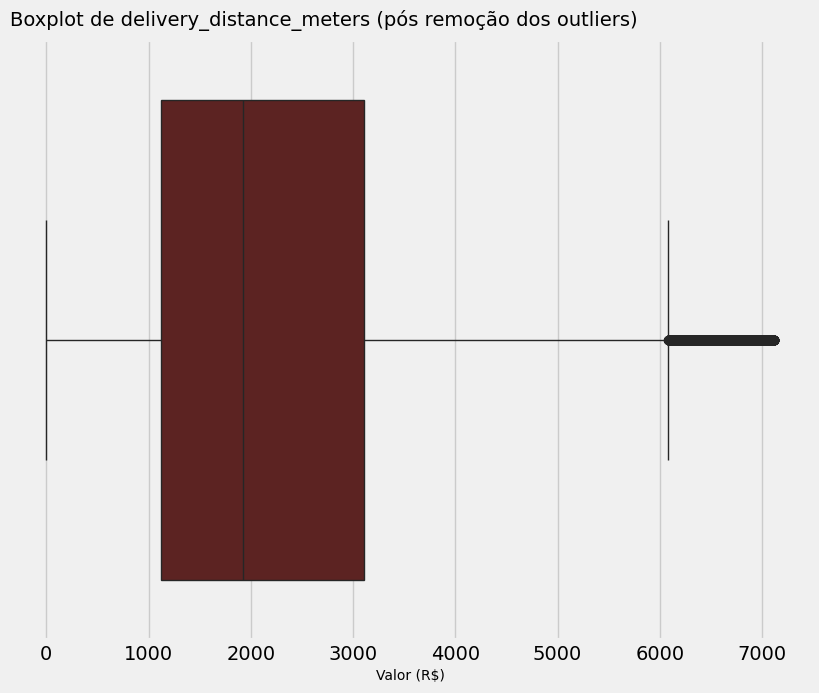

In [24]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0, 0, 1, 1])

sns.boxplot(df, x = 'delivery_distance_meters')
ax.set_title('Boxplot de delivery_distance_meters (pós remoção dos outliers)', loc = 'left', fontsize = 14, pad = 10)
ax.set_xlabel('Valor (R$)', fontsize = 10)
plt.show()

In [80]:
# Os dados limpos serão salvos também
df.to_csv("../data/processed/clean_data.csv", index = False)

# 3. Analisando os dados e respondendo as demandas

## 3.1. Os melhores entregadores

In [25]:
ranking_geral = df.groupby(['driver_id', 'driver_modal']).agg(total_meters = ('delivery_distance_meters', 'sum')).reset_index().sort_values(by = 'total_meters', ascending = False)
ranking_geral.reset_index(drop = True, inplace = True)

In [26]:
ranking_geral['placing'] = ranking_geral.index + 1
ranking_geral['dt_ref'] = '2024-07-08'
ranking_geral = ranking_geral[['dt_ref', 'placing', 'driver_id', 'driver_modal', 'total_meters']]
ranking_geral.head(20)

,dt_ref,placing,driver_id,driver_modal,total_meters
0,2024-07-08,1,25651,MOTOBOY,13854626.0
1,2024-07-08,2,26223,MOTOBOY,8340694.0
2,2024-07-08,3,7615,MOTOBOY,2599726.0
3,2024-07-08,4,9806,MOTOBOY,2295311.0
4,2024-07-08,5,4737,MOTOBOY,2286124.0
5,2024-07-08,6,7549,MOTOBOY,2283929.0
6,2024-07-08,7,11522,MOTOBOY,2212062.0
7,2024-07-08,8,7799,MOTOBOY,2184855.0
8,2024-07-08,9,15561,MOTOBOY,2097759.0
9,2024-07-08,10,902,MOTOBOY,2073159.0


#### Melhores motoboys

In [27]:
ranking_motoboys = ranking_geral[ranking_geral['driver_modal'] == 'MOTOBOY']
ranking_motoboys.reset_index(drop = True, inplace = True)
ranking_motoboys['placing'] = ranking_motoboys.index + 1
ranking_motoboys.head(20)

,dt_ref,placing,driver_id,driver_modal,total_meters
0,2024-07-08,1,25651,MOTOBOY,13854626.0
1,2024-07-08,2,26223,MOTOBOY,8340694.0
2,2024-07-08,3,7615,MOTOBOY,2599726.0
3,2024-07-08,4,9806,MOTOBOY,2295311.0
4,2024-07-08,5,4737,MOTOBOY,2286124.0
5,2024-07-08,6,7549,MOTOBOY,2283929.0
6,2024-07-08,7,11522,MOTOBOY,2212062.0
7,2024-07-08,8,7799,MOTOBOY,2184855.0
8,2024-07-08,9,15561,MOTOBOY,2097759.0
9,2024-07-08,10,902,MOTOBOY,2073159.0


#### Melhores bikers

In [28]:
ranking_bikers = ranking_geral[ranking_geral['driver_modal'] == 'BIKER']
ranking_bikers.reset_index(drop = True, inplace = True)
ranking_bikers['placing'] = ranking_bikers.index + 1
ranking_bikers.head(20)

,dt_ref,placing,driver_id,driver_modal,total_meters
0,2024-07-08,1,3780,BIKER,829689.0
1,2024-07-08,2,794,BIKER,826101.0
2,2024-07-08,3,12724,BIKER,696300.0
3,2024-07-08,4,7773,BIKER,604160.0
4,2024-07-08,5,18487,BIKER,597504.0
5,2024-07-08,6,12079,BIKER,560326.0
6,2024-07-08,7,14059,BIKER,559636.0
7,2024-07-08,8,4536,BIKER,553887.0
8,2024-07-08,9,9996,BIKER,553366.0
9,2024-07-08,10,1203,BIKER,542755.0


In [29]:
file_name = '../data/processed/ranking_entregadores.xlsx'

with pd.ExcelWriter(file_name, engine = 'xlsxwriter') as writer:
    ranking_geral.to_excel(writer, sheet_name = 'Ranking Geral', index = False)
    ranking_motoboys.to_excel(writer, sheet_name = 'Ranking dos Motoboys', index = False)
    ranking_bikers.to_excel(writer, sheet_name = 'Ranking dos Bikers', index = False)

Planilha salva em ../data/processed/ranking_entregadores.xlsx


## 3.2. Distância média percorrida em cada estado

In [82]:
dist = df.groupby('hub_state').agg(total_drivers = ('driver_id', 'nunique'), mean_delivery_distance = ('delivery_distance_meters', 'mean')).reset_index().sort_values(by = 'mean_delivery_distance', ascending=False)
dist['dt_ref'] = '2024-07-08'
dist = dist[['dt_ref', 'hub_state', 'total_drivers', 'mean_delivery_distance']]
dist

,dt_ref,hub_state,total_drivers,mean_delivery_distance
2,2024-07-08,RS,216,2890.157412
0,2024-07-08,PR,291,2624.129476
3,2024-07-08,SP,2051,2246.582950
1,2024-07-08,RJ,1907,2010.072113


## 3.3. Receitas

#### Receita média: Good x Food

In [67]:
mean_revenue = df.groupby(['store_id', 'hub_state', 'store_segment']).agg(mean_order_revenue = ('order_revenue', 'mean')).reset_index()
mean_revenue['mean_order_revenue'] = mean_revenue['mean_order_revenue'].round(2)
mean_revenue['dt_ref'] = '2024-07-09'
mean_revenue = mean_revenue[['dt_ref', 'store_id', 'hub_state', 'store_segment', 'mean_order_revenue']]
mean_revenue

,dt_ref,store_id,hub_state,store_segment,mean_order_revenue
0,2024-07-09,6,RS,FOOD,2.48
1,2024-07-09,8,RS,FOOD,1.50
2,2024-07-09,53,RJ,FOOD,4.51
3,2024-07-09,54,RJ,FOOD,7.24
4,2024-07-09,56,RJ,FOOD,-2.73
...,...,...,...,...,...
804,2024-07-09,4637,RJ,FOOD,3.82
805,2024-07-09,4648,SP,FOOD,1.92
806,2024-07-09,4650,SP,FOOD,9.66
807,2024-07-09,4675,RJ,GOOD,15.55


In [91]:
# Observando os dados absolutos

absm_revenue = df.groupby('store_segment').agg(mean_order_revenue = ('order_revenue', 'mean')).round(2).reset_index()
absm_revenue

,store_segment,mean_order_revenue
0,FOOD,6.08
1,GOOD,12.61


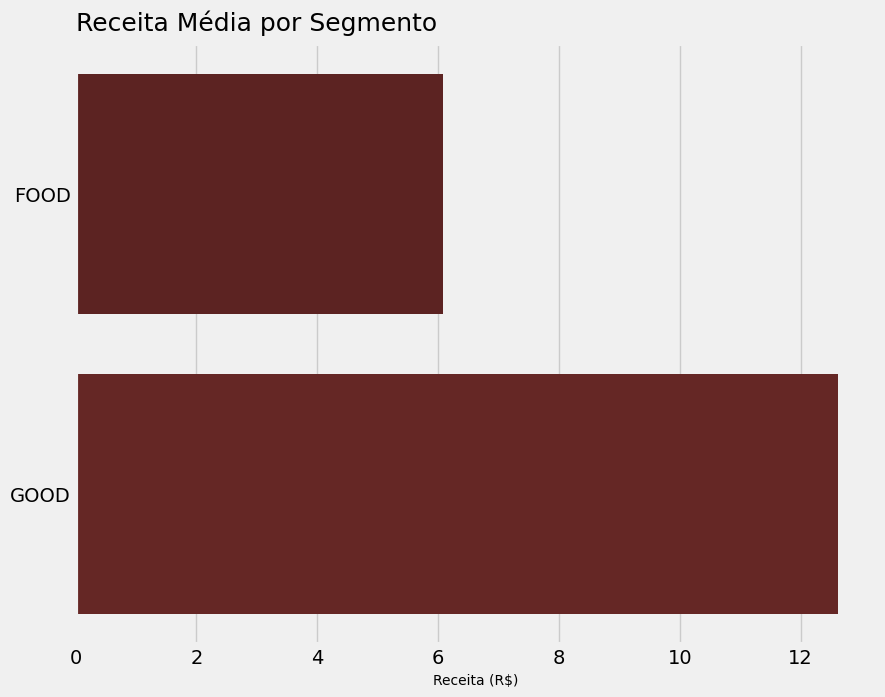

In [94]:
fig = plt.figure(figsize = (8, 6))
ax = fig.add_axes([0, 0, 1 , 1])

sns.barplot(absm_revenue, x = 'mean_order_revenue', y = 'store_segment', palette = my_palette)
ax.set_title('Receita Média por Segmento', loc = 'left', fontsize = 18, pad = 10)
ax.set_xlabel('Receita (R$)', fontsize = 10)
ax.set_ylabel('')
plt.show()

#### Receita total: Good x Food

In [65]:
total_revenue = df.groupby(['store_id', 'hub_state', 'store_segment']).agg(total_order_revenue = ('order_revenue', 'sum')).reset_index()
total_revenue['total_order_revenue'] = total_revenue['total_order_revenue'].round(2)
total_revenue['dt_ref'] = '2024-07-08'
total_revenue = total_revenue[['dt_ref', 'store_id', 'hub_state', 'store_segment', 'total_order_revenue']]
total_revenue

,dt_ref,store_id,hub_state,store_segment,total_order_revenue
0,2024-07-08,6,RS,FOOD,8777.10
1,2024-07-08,8,RS,FOOD,3353.08
2,2024-07-08,53,RJ,FOOD,61494.93
3,2024-07-08,54,RJ,FOOD,535.43
4,2024-07-08,56,RJ,FOOD,-8643.39
...,...,...,...,...,...
804,2024-07-08,4637,RJ,FOOD,106.86
805,2024-07-08,4648,SP,FOOD,128.91
806,2024-07-08,4650,SP,FOOD,6590.25
807,2024-07-08,4675,RJ,GOOD,15.55


In [95]:
# Observando os dados absolutos

abst_revenue = df.groupby('store_segment').agg(total_order_revenue = ('order_revenue', 'sum')).round(2).reset_index()
abst_revenue

,store_segment,total_order_revenue
0,FOOD,1756841.99
1,GOOD,253492.26


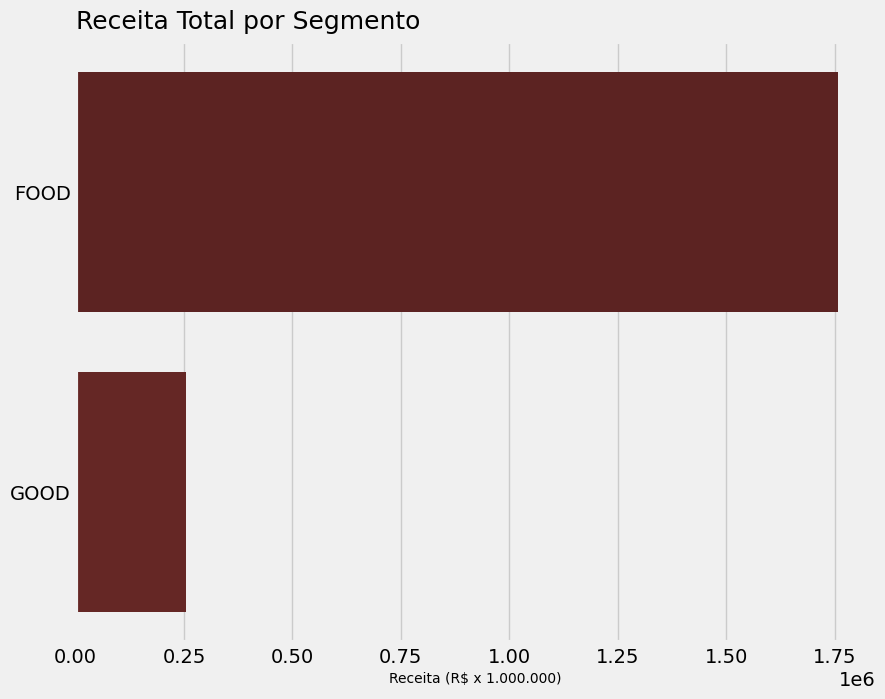

In [97]:
fig = plt.figure(figsize = (8, 6))
ax = fig.add_axes([0, 0, 1 , 1])

sns.barplot(abst_revenue, x = 'total_order_revenue', y = 'store_segment', palette = my_palette)
ax.set_title('Receita Total por Segmento', loc = 'left', fontsize = 18, pad = 10)
ax.set_xlabel('Receita (R$ x 1.000.000)', fontsize = 10)
ax.set_ylabel('')
plt.show()

#### Receita média: estados

In [69]:
state_revenue = df.groupby(['hub_state']).agg(total_stores = ('store_id', 'nunique'), total_drivers = ('driver_id', 'nunique'), mean_order_revenue = ('order_revenue', 'mean')).reset_index()
state_revenue['mean_order_revenue'] = state_revenue['mean_order_revenue'].round(2)
state_revenue['dt_ref'] = '2024-07-08'
state_revenue = state_revenue[['dt_ref', 'hub_state', 'total_stores', 'total_drivers', 'mean_order_revenue']]
state_revenue

,dt_ref,hub_state,total_stores,total_drivers,mean_order_revenue
0,2024-07-08,PR,100,291,2.40
1,2024-07-08,RJ,275,1907,6.52
2,2024-07-08,RS,40,216,4.14
3,2024-07-08,SP,394,2051,7.79


In [98]:
# Observando os dados absolutos 

abstate_mean = df.groupby('hub_state').agg(mean_order_revenue = ('order_revenue', 'mean')).round(2).reset_index().sort_values(by = 'mean_order_revenue', ascending = False)
abstate_mean

,hub_state,mean_order_revenue
3,SP,7.79
1,RJ,6.52
2,RS,4.14
0,PR,2.40


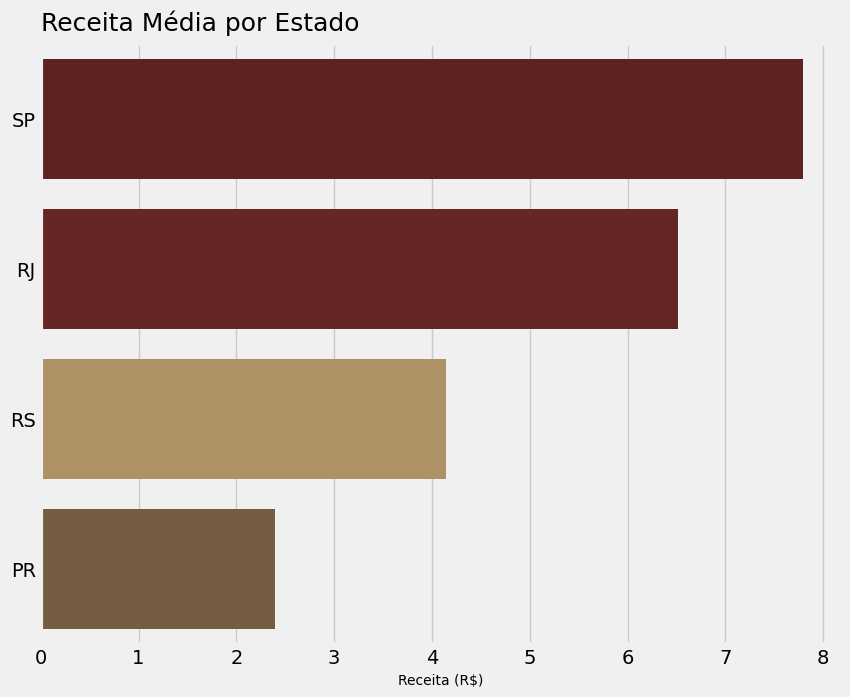

In [100]:
fig = plt.figure(figsize = (8, 6))
ax = fig.add_axes([0, 0, 1 , 1])

sns.barplot(abstate_mean, x = 'mean_order_revenue', y = 'hub_state', palette = my_palette)
ax.set_title('Receita Média por Estado', loc = 'left', fontsize = 18, pad = 10)
ax.set_xlabel('Receita (R$)', fontsize = 10)
ax.set_ylabel('')
plt.show()

#### Receita total: estados

In [70]:
state_total = df.groupby(['hub_state']).agg(total_stores = ('store_id', 'nunique'), total_drivers = ('driver_id', 'nunique'), total_order_revenue = ('order_revenue', 'sum')).reset_index()
state_total['total_order_revenue'] = state_total['total_order_revenue'].round(2)
state_total['dt_ref'] = '2024-07-08'
state_total = state_total[['dt_ref', 'hub_state', 'total_stores', 'total_drivers', 'total_order_revenue']]
state_total

,dt_ref,hub_state,total_stores,total_drivers,total_order_revenue
0,2024-07-08,PR,100,291,60085.45
1,2024-07-08,RJ,275,1907,785328.08
2,2024-07-08,RS,40,216,123573.03
3,2024-07-08,SP,394,2051,1041347.69


In [103]:
# Observando os dados absolutos

abstate_total = df.groupby('hub_state').agg(total_orders_revenue = ('order_revenue', 'sum')).round(2).reset_index().sort_values(by = 'total_orders_revenue', ascending = False)
abstate_total

,hub_state,total_orders_revenue
3,SP,1041347.69
1,RJ,785328.08
2,RS,123573.03
0,PR,60085.45


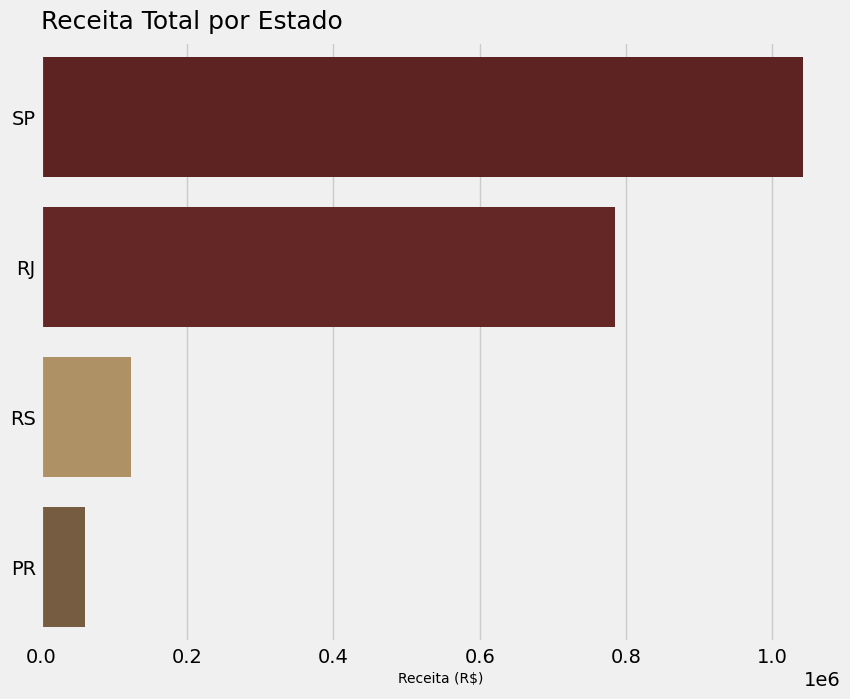

In [104]:
fig = plt.figure(figsize = (8, 6))
ax = fig.add_axes([0, 0, 1 , 1])

sns.barplot(abstate_total, x = 'total_orders_revenue', y = 'hub_state', palette = my_palette)
ax.set_title('Receita Total por Estado', loc = 'left', fontsize = 18, pad = 10)
ax.set_xlabel('Receita (R$)', fontsize = 10)
ax.set_ylabel('')
plt.show()

Os resultados serão salvos em uma planilha, assim como os dos entregadores.

In [71]:
file_name = '../data/processed/receitas_goodxfood.xlsx'

with pd.ExcelWriter(file_name, engine = 'xlsxwriter') as writer:
    mean_revenue.to_excel(writer, sheet_name = 'Receita Média Good x Food', index = False)
    total_revenue.to_excel(writer, sheet_name = 'Receita Total Good x Food', index = False)
    state_revenue.to_excel(writer, sheet_name = 'Receita Média Estados', index = False)
    state_total.to_excel(writer, sheet_name = 'Receita Total Estados', index = False)

## 3.4. Bônus para os funcionários

In [79]:
print(f"O faturamento total foi de R${round(df['order_revenue'].sum(), 2)} e o bônus para o funcionários é de R${round(((df['order_revenue'].sum() * 0.20) / 2000), 2)}.")

O faturamento total foi de R$2010334.24 e o bônus para o funcionários é de R$201.03.
